# One Vs All

Realizando classificação com KNN usando para treino os arquivos `chbNN_com_dwt.csv` onde `NN` pertence ao `chb_set`, com exceção do que será usado para teste.

## Importando bibliotecas

In [1]:
import numpy as np
import pandas as pd

from seaborn import heatmap
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

chb_set = set([
    '01', '02', '03', '04', '05', '07', '08',
    '10', '11', '12', '13', '14', '15', '16',
    '17', '18', '19', '21', '22', '23', '24'
])

group_names = ['True Neg','False Pos','False Neg','True Pos']

test_element: chb03	test_samples: 392
              precision    recall  f1-score   support

    negative     0.9694    0.9694    0.9694       196
    positive     0.9694    0.9694    0.9694       196

    accuracy                         0.9694       392
   macro avg     0.9694    0.9694    0.9694       392
weighted avg     0.9694    0.9694    0.9694       392



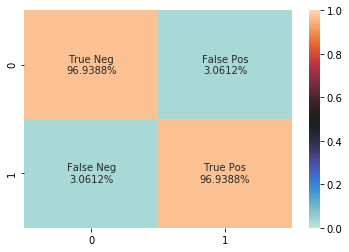

test_element: chb14	test_samples: 156
              precision    recall  f1-score   support

    negative     0.7379    0.9744    0.8398        78
    positive     0.9623    0.6538    0.7786        78

    accuracy                         0.8141       156
   macro avg     0.8501    0.8141    0.8092       156
weighted avg     0.8501    0.8141    0.8092       156



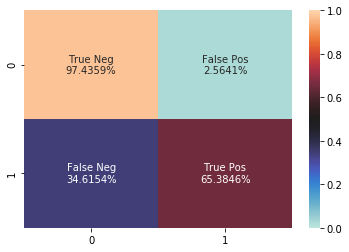

test_element: chb18	test_samples: 306
              precision    recall  f1-score   support

    negative     0.8596    1.0000    0.9245       153
    positive     1.0000    0.8366    0.9110       153

    accuracy                         0.9183       306
   macro avg     0.9298    0.9183    0.9178       306
weighted avg     0.9298    0.9183    0.9178       306



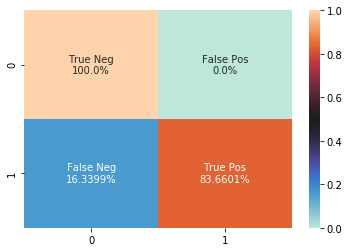

test_element: chb05	test_samples: 550
              precision    recall  f1-score   support

    negative     0.9636    0.9636    0.9636       275
    positive     0.9636    0.9636    0.9636       275

    accuracy                         0.9636       550
   macro avg     0.9636    0.9636    0.9636       550
weighted avg     0.9636    0.9636    0.9636       550



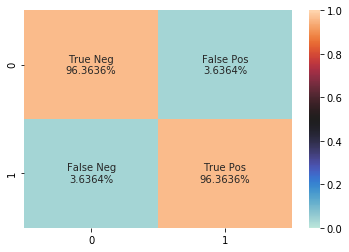

test_element: chb19	test_samples: 232
              precision    recall  f1-score   support

    negative     0.8712    0.9914    0.9274       116
    positive     0.9900    0.8534    0.9167       116

    accuracy                         0.9224       232
   macro avg     0.9306    0.9224    0.9220       232
weighted avg     0.9306    0.9224    0.9220       232



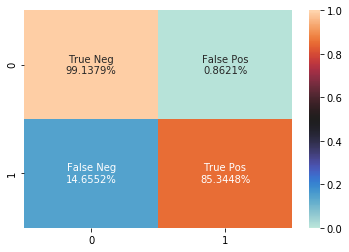

test_element: chb22	test_samples: 198
              precision    recall  f1-score   support

    negative     0.9794    0.9596    0.9694        99
    positive     0.9604    0.9798    0.9700        99

    accuracy                         0.9697       198
   macro avg     0.9699    0.9697    0.9697       198
weighted avg     0.9699    0.9697    0.9697       198



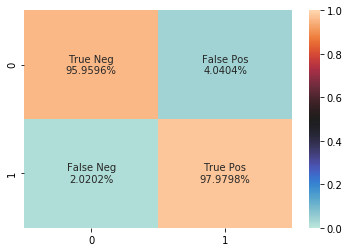

test_element: chb21	test_samples: 192
              precision    recall  f1-score   support

    negative     0.8348    1.0000    0.9100        96
    positive     1.0000    0.8021    0.8902        96

    accuracy                         0.9010       192
   macro avg     0.9174    0.9010    0.9001       192
weighted avg     0.9174    0.9010    0.9001       192



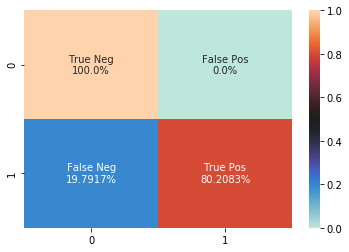

test_element: chb13	test_samples: 516
              precision    recall  f1-score   support

    negative     0.8873    0.9767    0.9299       258
    positive     0.9741    0.8760    0.9224       258

    accuracy                         0.9264       516
   macro avg     0.9307    0.9264    0.9262       516
weighted avg     0.9307    0.9264    0.9262       516



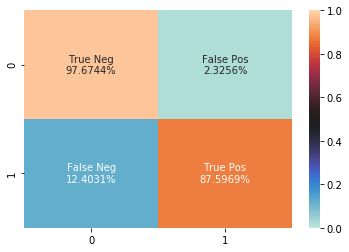

test_element: chb07	test_samples: 320
              precision    recall  f1-score   support

    negative     0.9750    0.9750    0.9750       160
    positive     0.9750    0.9750    0.9750       160

    accuracy                         0.9750       320
   macro avg     0.9750    0.9750    0.9750       320
weighted avg     0.9750    0.9750    0.9750       320



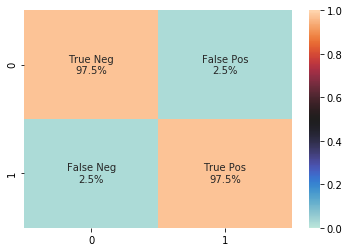

test_element: chb15	test_samples: 224
              precision    recall  f1-score   support

    negative     0.9737    0.9911    0.9823       112
    positive     0.9909    0.9732    0.9820       112

    accuracy                         0.9821       224
   macro avg     0.9823    0.9821    0.9821       224
weighted avg     0.9823    0.9821    0.9821       224



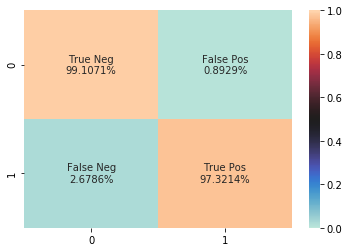

test_element: chb12	test_samples: 952
              precision    recall  f1-score   support

    negative     0.8330    0.9643    0.8939       476
    positive     0.9576    0.8067    0.8757       476

    accuracy                         0.8855       952
   macro avg     0.8953    0.8855    0.8848       952
weighted avg     0.8953    0.8855    0.8848       952



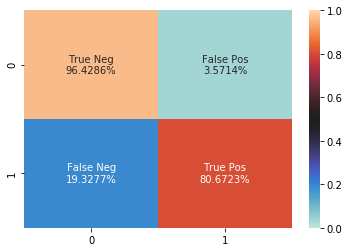

test_element: chb02	test_samples: 168
              precision    recall  f1-score   support

    negative     0.8817    0.9762    0.9266        84
    positive     0.9733    0.8690    0.9182        84

    accuracy                         0.9226       168
   macro avg     0.9275    0.9226    0.9224       168
weighted avg     0.9275    0.9226    0.9224       168



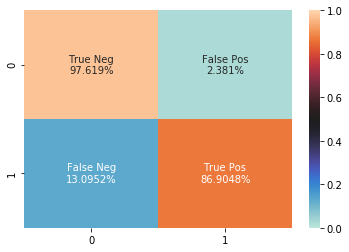

test_element: chb11	test_samples: 800
              precision    recall  f1-score   support

    negative     0.9452    0.9925    0.9683       400
    positive     0.9921    0.9425    0.9667       400

    accuracy                         0.9675       800
   macro avg     0.9687    0.9675    0.9675       800
weighted avg     0.9687    0.9675    0.9675       800



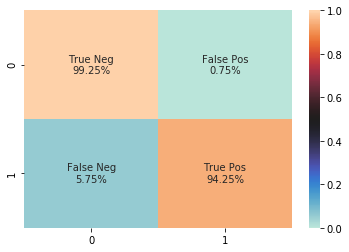

test_element: chb04	test_samples: 372
              precision    recall  f1-score   support

    negative     0.9620    0.9516    0.9568       186
    positive     0.9521    0.9624    0.9572       186

    accuracy                         0.9570       372
   macro avg     0.9570    0.9570    0.9570       372
weighted avg     0.9570    0.9570    0.9570       372



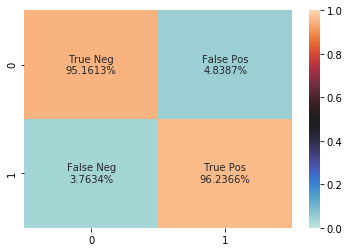

test_element: chb16	test_samples: 68
              precision    recall  f1-score   support

    negative     0.5909    0.7647    0.6667        34
    positive     0.6667    0.4706    0.5517        34

    accuracy                         0.6176        68
   macro avg     0.6288    0.6176    0.6092        68
weighted avg     0.6288    0.6176    0.6092        68



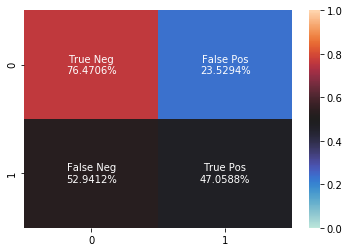

test_element: chb24	test_samples: 488
              precision    recall  f1-score   support

    negative     0.8392    0.9836    0.9057       244
    positive     0.9802    0.8115    0.8879       244

    accuracy                         0.8975       488
   macro avg     0.9097    0.8975    0.8968       488
weighted avg     0.9097    0.8975    0.8968       488



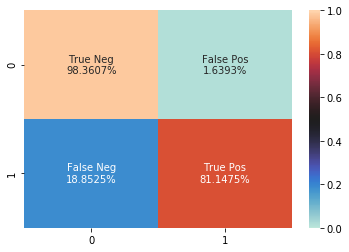

test_element: chb01	test_samples: 432
              precision    recall  f1-score   support

    negative     0.9677    0.9722    0.9700       216
    positive     0.9721    0.9676    0.9698       216

    accuracy                         0.9699       432
   macro avg     0.9699    0.9699    0.9699       432
weighted avg     0.9699    0.9699    0.9699       432



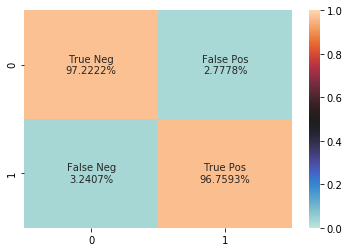

test_element: chb10	test_samples: 436
              precision    recall  f1-score   support

    negative     0.9513    0.9862    0.9685       218
    positive     0.9857    0.9495    0.9673       218

    accuracy                         0.9679       436
   macro avg     0.9685    0.9679    0.9679       436
weighted avg     0.9685    0.9679    0.9679       436



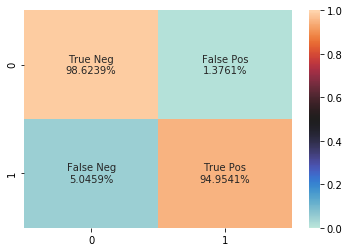

test_element: chb23	test_samples: 414
              precision    recall  f1-score   support

    negative     0.9712    0.9758    0.9735       207
    positive     0.9757    0.9710    0.9734       207

    accuracy                         0.9734       414
   macro avg     0.9734    0.9734    0.9734       414
weighted avg     0.9734    0.9734    0.9734       414



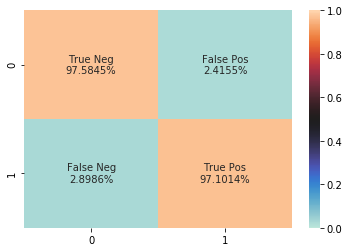

test_element: chb17	test_samples: 288
              precision    recall  f1-score   support

    negative     0.8684    0.9167    0.8919       144
    positive     0.9118    0.8611    0.8857       144

    accuracy                         0.8889       288
   macro avg     0.8901    0.8889    0.8888       288
weighted avg     0.8901    0.8889    0.8888       288



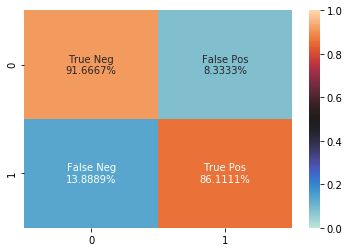

test_element: chb08	test_samples: 910
              precision    recall  f1-score   support

    negative     0.8695    0.9516    0.9087       455
    positive     0.9466    0.8571    0.8997       455

    accuracy                         0.9044       910
   macro avg     0.9080    0.9044    0.9042       910
weighted avg     0.9080    0.9044    0.9042       910



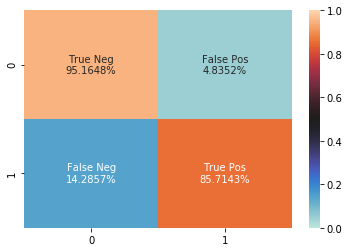

In [2]:
for test_element in chb_set:

    # Instanciando modelo
    model = KNeighborsClassifier()

    # Treinando com os demais chb
    chb_train_list = [
        pd.read_csv(f'./chb{train_element}/chb{train_element}_com_dwt.csv') for train_element in chb_set.difference(test_element)
    ]
    chb_df = pd.concat(chb_train_list)
    target_s = chb_df.pop('target')

    model.fit(chb_df.values, target_s.values)
    
    chb_test_df = pd.read_csv(f'./chb{test_element}/chb{test_element}_com_dwt.csv')
    target_test_s = chb_test_df.pop('target')

    y_pred = model.predict(chb_test_df.values)

    cf_mat = confusion_matrix(y_true=target_test_s.values,y_pred=y_pred,normalize='true')

    heatmap_labels = np.asarray(
        [f'{name}\n{round(100 * percentage, 4)}%' for name, percentage in zip(group_names, cf_mat.flatten())]
    ).reshape(2, 2)

    print(f'test_element: chb{test_element}\ttest_samples: {chb_test_df.shape[0]}')

    print(classification_report(
        y_true=target_test_s.values,
        y_pred=y_pred,
        target_names=['negative', 'positive'],
        digits=4
    ))

    heatmap(
        data=cf_mat,
        vmin=0,
        center=0.5,
        vmax=1,
        fmt='',
        annot=heatmap_labels
    )
    plt.show()